#Dependencies

In [21]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph ipython -q

#Necessary Libraries

In [22]:
import requests
import json
import random
import os, getpass

from datetime import datetime, timedelta
from typing import TypedDict, Annotated, List, Dict, Any
from IPython.display import display, Image

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.prebuilt import create_react_agent
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate


#Helper method for APIs

In [23]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

#Set the APIs

In [24]:
_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("OPENWEATHER_API_KEY")
_set_env("EXCHANGE_RATE_API_KEY")

#LLM

In [25]:
# Initialize LLM
llm = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile"
)

#State

In [26]:
# Define our State structure to maintain data flow between agents
class TravelState(TypedDict):
    messages: List[Any]  # Store conversation messages
    city: str  # Target city for travel
    weather_info: Dict[str, Any]  # Weather data and clothing recommendations
    hotel_info: Dict[str, Any]
    budget_info: Dict[str, Any]
    city_info: Dict[str, Any]  # Hotel search results
    travel_plan: str  # Final travel plan
    travel_date: str  # Travel date

# Tools

In [27]:
#@title tavily_tools


tavily_tool = TavilySearchResults(max_results=2)

In [28]:
#@title get_weather_tool

@tool
def get_weather(city: str, date: str):
    """
    Takes a city name and date, and returns the weather forecast for that date from the OpenWeatherMap API.

    Parameters:
    city (str): The name of the city for which weather information is requested.
    date (str): The date in "YYYY-MM-DD" format.

    Returns:
    dict: Weather information (temperature, wind speed, probability of rain).
    str: Error message (if the request fails).
    """
    url = "https://api.openweathermap.org/data/2.5/forecast"
    api_key = os.environ.get("OPENWEATHER_API_KEY")

    params = {
        "q": city,
        "appid": api_key,
        "units": "metric",
        "cnt": 40  # Retrieves data in 3-hour intervals for up to 5 days
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()

        if response.status_code == 200:
            forecast_list = data['list']
            selected_date_weather = []

            for forecast in forecast_list:
                forecast_time = datetime.utcfromtimestamp(forecast['dt']).strftime('%Y-%m-%d')

                if forecast_time == date:
                    selected_date_weather.append({
                        'time': datetime.utcfromtimestamp(forecast['dt']).strftime('%H:%M'),
                        'temperature': forecast['main']['temp'],
                        'wind_speed': forecast['wind']['speed'],
                        'rain_probability': forecast.get('clouds', {}).get('all', 0)
                    })

            if selected_date_weather:
                return {
                    'City': data['city']['name'],
                    'Date': date,
                    'Forecasts': selected_date_weather
                }
            else:
                return f"No weather data found for {date}."

        else:
            return f"Error: {data['message']}"

    except Exception as e:
        return f"An error occurred: {str(e)}"


In [29]:
#@title get_historical_places tool
@tool
def get_historical_places(city_name, limit=10, language="en"):
    """
    Fetches historical places in the specified city using the Wikipedia API.

    Parameters:
    city_name (str): Name of the city to search for historical places
    limit (int): Maximum number of results to return (default: 10)
    language (str): Wikipedia language code (default: "en" - English)

    Returns:
    list: List of historical places or None if an error occurs
    """
    # Wikipedia API endpoint
    url = f"https://{language}.wikipedia.org/w/api.php"

    # Create more specific search queries
    search_queries = [
        f"historical places {city_name}",
        f"{city_name} historical structures",
        f"{city_name} museums",
        f"{city_name} monuments"
    ]

    if language == "en":
        search_queries = [
            f"historical landmarks in {city_name}",
            f"historical monuments in {city_name}",
            f"museums in {city_name}",
            f"ancient sites in {city_name}"
        ]

    all_results = []
    used_titles = set()  # To prevent duplicate titles

    for query in search_queries:
        try:
            # API parameters
            params = {
                "action": "query",
                "format": "json",
                "list": "search",
                "srsearch": query,
                "srlimit": limit,
                "srprop": "snippet"
            }

            # Make API request
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()

            # Get search results
            if "query" in data and "search" in data["query"]:
                search_results = data["query"]["search"]

                # Process each result
                for result in search_results:
                    # Skip if title already added
                    if result["title"] in used_titles:
                        continue

                    # Filter results that contain the city name or are related to historical places
                    if (city_name.lower() in result["title"].lower() or
                        "historical" in result["title"].lower() or
                        "mosque" in result["title"].lower() or
                        "palace" in result["title"].lower() or
                        "museum" in result["title"].lower() or
                        "monument" in result["title"].lower() or
                        "church" in result["title"].lower() or
                        "cathedral" in result["title"].lower() or
                        "temple" in result["title"].lower() or
                        "castle" in result["title"].lower() or
                        "ruins" in result["title"].lower() or
                        "ancient" in result["title"].lower()):

                        place = {
                            "title": result["title"],
                            "snippet": result["snippet"].replace("<span class=\"searchmatch\">", "").replace("</span>", "")
                        }
                        all_results.append(place)
                        used_titles.add(result["title"])

                        # Exit loop if limit is reached
                        if len(all_results) >= limit:
                            break

            # Exit loop if limit is reached
            if len(all_results) >= limit:
                break

        except requests.exceptions.RequestException as e:
            print(f"API request error: {e}")
            continue
        except KeyError as e:
            print(f"Data processing error: {e}")
            continue

    # # Print results
    # print(f"\nHistorical Places in {city_name}:")
    # if not all_results:
    #     print("No results found.")
    # else:
    #     for i, place in enumerate(all_results, 1):
    #         print(f"\n{i}. {place['title']}")
    #         print(f"Description: {place['snippet']}")

    return all_results

In [30]:
#@title get_currency_rates tool
@tool
def get_currency_rates(base_currency='TRY', target_currencies=None):
    """
    Fetches currency exchange rate information using the exchangerate-api.com service

    Args:
        base_currency (str): The base currency code (e.g., 'USD', 'EUR')
        target_currencies (str or list): The target currency code(s) to convert to

    Returns:
        dict: Dictionary containing exchange rate data
    """
    api_key = os.environ['EXCHANGE_RATE_API_KEY']  # Replace with your actual API key
    try:
        # Build the URL with the API key and base currency
        url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/{base_currency}"

        # Fetch data from the API
        response = requests.get(url)

        # Check if the response is successful
        response.raise_for_status()

        # Parse the JSON response
        data = response.json()

        # Check if the API returned a successful response
        if data['result'] != 'success':
            raise Exception(f"API Error: {data.get('error', 'Unknown error')}")

        # Filter rates if target currencies are specified
        rates = data['conversion_rates']
        if target_currencies:
            # Convert single currency to list format
            if isinstance(target_currencies, str):
                target_currencies = [target_currencies]

            # Filter rates to only include requested currencies
            filtered_rates = {currency: rates[currency] for currency in target_currencies if currency in rates}
            rates = filtered_rates

        # Return only the needed information
        return {
            'base': base_currency,
            'date': data['time_last_update_utc'],
            'rates': rates
        }

    except requests.exceptions.RequestException as e:
        print(f"Error fetching currency rates: {e}")
        raise
    except KeyError as e:
        print(f"Unexpected API response format: {e}")
        raise

#Agents

In [31]:
# Create the weather agent
def create_weather_agent():
    weather_agent = create_react_agent(llm, [get_weather])
    return weather_agent

# Create the hotel search agent
def create_hotel_agent():
    # Using the Tavily hotel search tool
    hotel_agent = create_react_agent(llm, [tavily_tool])
    return hotel_agent

# Create the travel planner agent
def create_travel_planner_agent():
    travel_planner = create_react_agent(llm, [])
    return travel_planner

def extract_date_agent():
    date_agent = create_react_agent(llm, [])
    return date_agent

def city_info_agent():
    city_info = create_react_agent(llm, [get_historical_places])
    return city_info

def create_exchange_rate_agent():
    exchange_rate_info_agent = create_react_agent(llm, [get_currency_rates])
    return exchange_rate_info_agent

#Nodes

In [32]:
#@title exchange_rate_node

def exchange_rate_node(state: dict) -> dict:
    exchange_rate_agent = create_exchange_rate_agent()

    exchange_query = f"""
    I'm planning a trip from Turkey to {state['city']}.

    1. First, determine the local currency used in {state['city']}.
    2. Get the current exchange rate between Turkish Lira (TRY) and the local currency of {state['city']}.
    3. Based on this exchange rate, provide me with a budget breakdown for my trip to {state['city']}.

    Consider these typical expenses categories:
    - Accommodation (based on the hotels you found)
    - Meals (budget, mid-range, and high-end options)
    - Local transportation
    - Attractions and activities
    - Shopping

    Also suggest how much money I should exchange or if I should use credit cards.
    Compare costs between Turkey and {state['city']} to help me understand the relative expenses.
    """

    # Invoke the exchange rate agent
    response = exchange_rate_agent.invoke(
        {"messages": [HumanMessage(content=exchange_query)]}
    )

    # Extract the response
    budget_info = {
        "budget_plan": response["messages"][-1].content,
        "query_city": state["city"]
    }

    return {"budget_info": budget_info}

In [33]:
#@title city_info_node

def city_info_node(state: dict) -> dict:
    city_agent = city_info_agent()

    # Create a prompt for getting city information
    city_query = f"What are the most important cultural places and must-visit attractions in {state['city']}? Please provide places to visit"

    # Invoke the city information agent
    response = city_agent.invoke(
        {"messages": [HumanMessage(content=city_query)]}
    )

    # Extract the response
    city_info = {
        "attractions": response["messages"][-1].content,
        "query_city": state["city"]
    }

    return {"city_info": city_info}

In [34]:
#@title extract_date_node

def extract_date_node(state: TravelState) -> Dict[str, Any]:

    todays_date = datetime.today().strftime("%Y-%m-%d")
    user_message = state["messages"][-1].content


    prompt = PromptTemplate(
        input_variables=["text"],
        template="You are a date parsing assistant. Convert natural language date expressions to YYYY-MM-DD format. If the user mentions a day of the week, assume it's for the upcoming week. Return only the date with no additional text. Here is the todays date: {todays_date}\n\nRequest: {text}\n\nCity:"
    )


    message = HumanMessage(content=prompt.format(text=user_message, todays_date=todays_date))


    travel_date = llm.invoke([message]).content.strip()

    return {"travel_date": travel_date}

In [35]:
#@title extract_city_node

# Node function to extract city from user input
def extract_city_node(state: TravelState) -> Dict[str, Any]:
    # Extract the latest user message
    user_message = state["messages"][-1].content

    # Create a prompt to extract the city
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract the name of the city mentioned in the following request. Return only the city name with no additional text.\n\nRequest: {text}\n\nCity:"
    )

    # Format the prompt with the user message
    message = HumanMessage(content=prompt.format(text=user_message))

    # Invoke the LLM to extract the city
    city = llm.invoke([message]).content.strip()

    return {"city": city}

In [36]:
#@title weather_node

# Node function to get weather and clothing recommendations
def weather_node(state: TravelState) -> Dict[str, Any]:
    weather_agent = create_weather_agent()

    weather_query = f"What's the weather in {state['city']}? in {state['travel_date']} Also, what clothes should I pack for this weather?"

    # Invoke the weather agent
    response = weather_agent.invoke(
        {"messages": [HumanMessage(content=weather_query)]}
    )

    # Extract the response
    weather_info = {
        "forecast": response["messages"][-1].content,
        "query_city": state["city"]
    }

    return {"weather_info": weather_info}

In [37]:
#@title hotel_search_node

# Node function to search for hotels
def hotel_search_node(state: TravelState) -> Dict[str, Any]:
    hotel_agent = create_hotel_agent()

    # Create a prompt for hotel search
    hotel_query = f"Find me the top 3 hotels in {state['city']} with their ratings, price ranges, and key amenities."

    # Invoke the hotel search agent
    response = hotel_agent.invoke(
        {"messages": [HumanMessage(content=hotel_query)]}
    )

    # Extract the response
    hotel_info = {
        "results": response["messages"][-1].content,
        "query_city": state["city"]
    }

    return {"hotel_info": hotel_info}

In [38]:
#@title travel_plan_node

# Node function to create the travel plan
def travel_plan_node(state: TravelState) -> Dict[str, Any]:
    travel_planner_agent = create_travel_planner_agent()

    # Create a prompt for the travel planner
    planning_prompt = f"""
    Create a comprehensive travel plan for {state['city']} based on the following information:

    WEATHER INFORMATION:
    {state['weather_info']['forecast']}

    CITY ATTRACTIONS AND CULTURAL PLACES:
    {state['city_info']['attractions']}

    HOTEL OPTIONS:
    {state['hotel_info']['results']}

    BUDGET AND EXCHANGE RATE INFORMATION:
    {state['budget_info']['budget_plan']}

    Please include:
    1. Daily activities considering the weather and must-visit places
    2. Recommended hotel from the options
    3. Packing list based on the weather and write the weather forecast
    4. Budget considerations and money management tips
    5. Cultural insights and special recommendations for this destination
    """

    # Invoke the travel planner agent
    response = travel_planner_agent.invoke(
        {"messages": [HumanMessage(content=planning_prompt)]}
    )

    # Extract the response
    travel_plan = response["messages"][-1].content

    return {"travel_plan": travel_plan, "messages": state["messages"] + [HumanMessage(content=travel_plan)]}

#Build Graph and Visualize

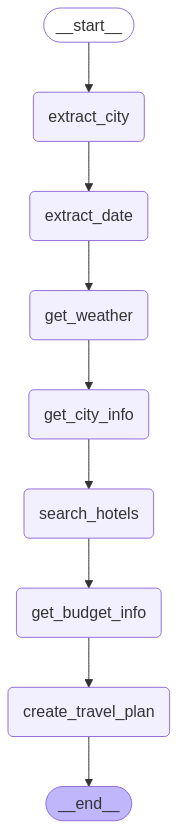

In [39]:
# Build the workflow
def build_travel_planning_workflow():
    # Initialize the graph
    workflow = StateGraph(TravelState)

    # Add nodes to the graph
    workflow.add_node("extract_city", extract_city_node)
    workflow.add_node("extract_date", extract_date_node)
    workflow.add_node("get_weather", weather_node)
    workflow.add_node("get_city_info", city_info_node)
    workflow.add_node("search_hotels", hotel_search_node)
    workflow.add_node("get_budget_info", exchange_rate_node)  # Add the new node
    workflow.add_node("create_travel_plan", travel_plan_node)

    # Define the sequential flow according to requirements
    workflow.set_entry_point("extract_city")

    # City -> Date -> Weather -> City Info -> Hotel -> Budget -> Travel Plan -> END
    workflow.add_edge("extract_city", "extract_date")
    workflow.add_edge("extract_date", "get_weather")
    workflow.add_edge("get_weather", "get_city_info")
    workflow.add_edge("get_city_info", "search_hotels")
    workflow.add_edge("search_hotels", "get_budget_info")  # Hotel -> Budget
    workflow.add_edge("get_budget_info", "create_travel_plan")  # Budget -> Travel Plan
    workflow.add_edge("create_travel_plan", END)

    # Compile the graph
    return workflow.compile()

from IPython.display import Image, display

try:
    display(Image(build_travel_planning_workflow().get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#Run The Assistant

In [40]:
# Build the travel planning workflow
travel_app = build_travel_planning_workflow()

# Initialize with a user query
user_query = "I'm planning a trip to San Francisco this saturday. Can you help me plan my trip?"

# Set up the initial state
initial_state = {
    "messages": [HumanMessage(content=user_query)],
    "city": "",
    "weather_info": {},
    "city_info": {},
    "hotel_info": {},
    "budget_info": {},
    "travel_plan": "",
    "travel_date": ""
}


# Execute the workflow
result = travel_app.invoke(initial_state)

# Print the final travel plan
print("\n===== FINAL TRAVEL PLAN =====\n")
print(result["travel_plan"])

# to see the agents responses.
# print("*\n"*150)
# print(result)
# print(result['hotel_info']['results'])
# print(result['weather_info']['forecast'])
# print(result['travel_date'])
# print("\n===== CITY INFORMATION =====\n")
# print(result["city_info"]["attractions"])
# print("\n===== BUDGET INFORMATION =====\n")
# print(result["budget_info"]["budget_plan"])


===== FINAL TRAVEL PLAN =====

**Comprehensive Travel Plan for San Francisco**

**Weather Forecast:**
For April 6, 2025, San Francisco is expected to be mostly cloudy with a high temperature of 16.46°C and a low of 11.65°C. There is a high probability of rain throughout the day, with a maximum probability of 100% at 21:00. The wind speed will be moderate, ranging from 0.62 to 4.63 m/s.

**Packing List:**

* Waterproof or water-resistant clothing (raincoat or umbrella)
* Layers of breathable clothing (t-shirts, sweaters, and light jackets)
* Comfortable shoes or boots with good grip
* Warm clothing (scarf or hat) for cooler morning and evening hours
* Power adapter for charging electronic devices
* Camera for capturing city attractions
* Reusable water bottle
* Snacks (especially for rainy days)

**Daily Activities:**

Day 1:

* 9:00 AM: Start the day with a visit to the **Presidio of San Francisco**, a former military base turned national park.
* 11:00 AM: Take a walk to the **San Fra